<a href="https://colab.research.google.com/github/as2c/MLP---Cosmology/blob/main/Optimization/SVM_data2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, our objective is to train some classic models such as SVM, KNN, RandomForest, etc on our test data, and try to evaluate their efficiency by plotting confusion matrixes, learning curves, validation curves, and measuring the prediction time. 

# Import phase I data

Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import timeit
import time
%alias_magic t timeit
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Gadget 2 Data / with Neutrino

In [4]:
data = pd.read_csv(r'/content/drive/MyDrive/denc_Neutrino')
# data['in_halo'] = (data['haloID']>0).astype('int')
data['in_halo'] = (data['halo_mass']>1600).astype('int32')
data

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,10156552,755,2280.0,171.21194,220.56293,-274.228700,-0.084922,-0.052028,-0.042415,-0.028087,-0.024984,-0.018675,-0.016231,-0.011940,-0.010111,1
1,11068486,85,1539.0,-129.84116,92.60424,212.125500,-0.127820,-0.081099,-0.051217,-0.028345,-0.013751,-0.013991,-0.012344,-0.011500,-0.012220,0
2,9530036,654,1944.0,-290.99210,-885.49430,468.255040,-0.078978,-0.052806,-0.030027,-0.011704,0.001295,0.003803,0.005131,0.005231,0.003787,1
3,11455022,752,1394.0,-60.35258,422.43716,79.394300,-0.109989,-0.079155,-0.054663,-0.037685,-0.026670,-0.017901,-0.009227,-0.000868,0.001568,0
4,8591034,356,1649.0,403.66608,345.88077,9.231552,-0.084405,-0.019068,-0.009396,-0.001539,0.002288,0.005629,0.011288,0.013111,0.013433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2160800,451,2634.0,654.82430,210.78130,255.344150,-0.094225,-0.076043,-0.060624,-0.040368,-0.020840,-0.016261,-0.011803,-0.005002,0.000918,1
99996,3257728,43,1112.0,-154.27774,488.65564,-779.558400,-0.127045,-0.076529,-0.056246,-0.038201,-0.027520,-0.016374,-0.008045,0.002627,0.006124,0
99997,6101605,484,1198.0,-113.51735,68.44336,275.964000,-0.122135,-0.091794,-0.063465,-0.032060,-0.017973,-0.016684,-0.017740,-0.017154,-0.012600,0
99998,4576456,44,1058.0,-130.21120,292.63483,-754.563000,-0.097585,-0.076140,-0.061788,-0.054584,-0.043055,-0.032415,-0.021591,-0.007463,0.004673,0


In [5]:
data.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.716004e+06,424.627710,2369.299450,35.207601,-13.728656,97.821939,-0.107338,-0.062074,-0.038666,-0.025951,-0.017900,-0.011968,-0.007224,-0.003341,-0.000224,0.557930
std,3.549230e+06,230.962533,1856.527585,364.820655,369.919751,373.578625,0.020301,0.020965,0.019921,0.018106,0.015956,0.013969,0.012346,0.011069,0.010084,0.496635
min,2.131444e+06,16.000000,241.000000,-1247.932500,-1462.806300,-1250.519700,-0.127820,-0.099572,-0.083351,-0.072824,-0.065316,-0.058751,-0.050519,-0.043771,-0.038371,0.000000
25%,5.953820e+06,238.000000,1194.000000,-226.284345,-254.656135,-145.829085,-0.124202,-0.077891,-0.052474,-0.038510,-0.028860,-0.021233,-0.015384,-0.010712,-0.006964,0.000000
50%,9.043250e+06,418.000000,1791.000000,32.857450,-4.815737,101.883413,-0.113607,-0.063404,-0.039434,-0.026100,-0.017784,-0.011980,-0.007369,-0.003743,-0.000713,1.000000
75%,1.176120e+07,619.000000,2945.000000,284.168098,238.543252,350.062135,-0.095776,-0.048722,-0.025370,-0.013587,-0.006677,-0.002087,0.001081,0.004249,0.006694,1.000000
max,1.464652e+07,870.000000,10101.000000,1314.092800,1256.822900,1355.984900,0.017155,0.032463,0.044346,0.040490,0.042179,0.036009,0.033482,0.034145,0.032602,1.000000


### Gadget 2 Data / without Neutrino

In [6]:
data_cdm = pd.read_csv(r'/content/drive/MyDrive/denc_CDM')
data_cdm['in_halo'] = (data_cdm['halo_mass']>1600).astype('int32')
data_cdm

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,8981131,414,1504.0,252.710050,-464.239500,509.94550,2.817576,2.780794,2.746420,2.446413,2.000415,1.533108,1.083378,0.691070,0.457584,0
1,9901676,1026,1013.0,-167.701370,499.161740,156.32635,2.690323,2.102417,1.805493,1.485764,1.267945,1.083753,0.849938,0.617267,0.431845,0
2,8288987,1079,727.0,46.129280,19.954561,164.61870,1.010590,0.821528,0.559744,0.220796,0.003400,-0.094805,-0.074599,0.003315,0.076079,0
3,4842631,675,1268.0,-234.629320,349.021400,-690.46674,1.889611,1.180236,0.495534,0.064434,-0.232441,-0.389582,-0.407908,-0.334146,-0.231578,0
4,12884124,437,6128.0,146.780670,-180.209270,-558.39777,2.676619,1.734870,0.906903,0.464721,0.187801,0.057663,0.029529,0.049055,0.101472,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12466311,1085,5542.0,25.253933,-580.586850,113.06337,1.482403,1.068278,0.857863,0.583947,0.327563,0.212553,0.139374,0.103515,0.090791,1
99996,11857185,491,691.0,-423.371550,138.109020,-300.80450,-0.209077,-0.534490,-0.724460,-0.749430,-0.743152,-0.663805,-0.511928,-0.347015,-0.253660,0
99997,9340191,947,868.0,225.385210,-9.085627,318.22006,1.086942,0.492283,0.114506,-0.050883,-0.161068,-0.168421,-0.159639,-0.175261,-0.202931,0
99998,13317963,1034,1175.0,-55.431606,16.332230,-898.90326,0.339088,-0.085185,-0.248881,-0.328230,-0.343797,-0.306353,-0.275684,-0.282089,-0.284524,0


In [7]:
data_cdm.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.533738e+06,633.075900,3004.391080,32.287533,-13.697343,89.574071,1.423915,1.032233,0.712873,0.480862,0.322917,0.216223,0.144046,0.096634,0.066060,0.589200
std,3.598448e+06,358.496156,2802.876192,359.880883,364.383569,374.571567,1.023549,0.920945,0.807251,0.689640,0.585773,0.502089,0.436403,0.384151,0.341271,0.491981
min,2.131195e+06,3.000000,271.000000,-1234.874100,-1571.376600,-1311.024700,-0.994127,-0.912349,-0.878283,-0.891915,-0.933043,-0.935449,-0.868262,-0.815454,-0.787467,0.000000
25%,5.640789e+06,368.000000,1181.000000,-223.982345,-249.685410,-148.388917,0.660156,0.354545,0.122621,-0.026842,-0.107359,-0.161173,-0.183527,-0.186967,-0.181568,0.000000
50%,8.790886e+06,676.000000,2020.000000,28.124724,-4.978945,97.944227,1.269011,0.890765,0.589027,0.370513,0.223129,0.134561,0.074502,0.037988,0.011761,1.000000
75%,1.143724e+07,970.000000,3662.000000,277.156240,231.618633,341.305498,2.057976,1.549992,1.162333,0.872826,0.674880,0.526476,0.422276,0.353801,0.294427,1.000000
max,1.464654e+07,1251.000000,31252.000000,1362.093800,1185.835400,1349.211900,5.624963,4.721646,3.972765,3.400808,2.783131,2.163220,1.888203,1.618024,1.364662,1.000000


## Define Datasets

In [8]:
## Neutrino
X = data.iloc[:,3:15].astype('float32').values
Y = data.in_halo.astype('int32').values

In [9]:
## CDM
X2 = data_cdm.iloc[:,3:15].astype('float32').values
Y2 = data_cdm.in_halo.astype('int32').values

In [10]:
## Scale / Neutrino
X = (X - np.mean(X))/np.std(X)

In [11]:
## Scale / CDM
X2 = (X2 - np.mean(X2))/np.std(X2)

In [12]:
## Split into test and train / Neutrino

tst_size = 0.2
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 80000    X_test : 20000


In [13]:
## Split into test and train / CDM

tst_size = 0.2
ns, nf = np.shape(X) 
X2_train, X2_test, Y2_train, Y2_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X2_train :',len(X2_train),'   X2_test :',len(X2_test))

X2_train : 80000    X2_test : 20000


In [14]:
# Frequency of 1-class / Neutrino
print("{} % of the stored data has class 1 ".format(100*Y.sum()/len(Y)))

55.793 % of the stored data has class 1 


In [15]:
# Frequency of 1-class / CDM
print("{} % of the stored data has class 1 ".format(100*Y2.sum()/len(Y2)))

58.92 % of the stored data has class 1 


# SVM 

Initialize and train svm model

In [ ]:
svc = svm.SVC(kernel='rbf',C=.1)

svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)

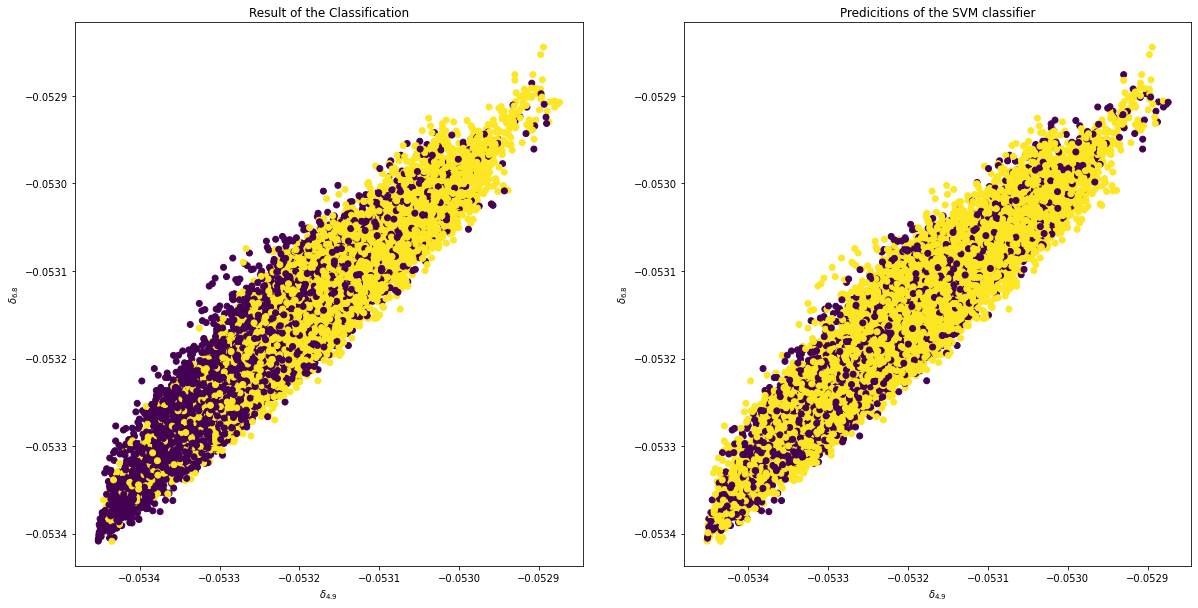

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$\delta_{4.9}$', ylabel='$\delta_{6.8}$' , title = 'Result of the Classification')

ax.scatter(*X_test[:,6:8].T, c=Y_test)    

ax = fig.add_subplot(122 , xlabel = '$\delta_{4.9}$ ', ylabel='$\delta_{6.8}$', title = 'Predicitions of the SVM classifier')
plt.scatter(*X_test[:,6:8].T, c = Y_pred)
plt.show()


In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.58      0.33      0.42      8852
           1       0.60      0.81      0.69     11148

    accuracy                           0.60     20000
   macro avg       0.59      0.57      0.56     20000
weighted avg       0.59      0.60      0.57     20000



### Fine Tunning The Hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'C': [0.1,1,.01],  
                'gamma': [0.001,.1,.01,1], 
                'kernel': ['rbf', 'sigmoid']}

In [ ]:
# Random search of parameters, using 2 fold cross validation, 
# search across 6 different combinations, and use all available cores
print('start')
svc= svm.SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, n_iter=6, cv = 2, verbose=2, random_state=42, n_jobs = -1, refit=True)
# Fit the random search model
svc_random.fit(X_train, Y_train)

print(svc_random.best_params_)

In [ ]:
print(svc_random.best_params_)

{'kernel': 'rbf', 'gamma': 0.1, 'C': 0.01}


In [ ]:
import pickle

# save the model to disk

filename = 'drive/MyDrive/svm_model.sav'
# pickle.dump(trained_model, open(filename, 'wb'))

# load the model from disk

clf_load = pickle.load(open(filename, 'rb'))


### Learning Curve


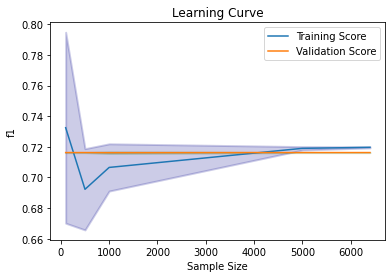

Training scores:

            cv1       cv2       cv3       cv4       cv5
100   0.857143  0.701299  0.701299  0.701299  0.701299
500   0.745295  0.678996  0.678996  0.678996  0.678996
1000  0.737374  0.698827  0.698827  0.698827  0.698827
5000  0.721228  0.718442  0.718442  0.718442  0.718442
6400  0.720384  0.719488  0.719488  0.719488  0.719488

 ----------------------------------------------------------------------

Validation scores:

            cv1       cv2       cv3       cv4       cv5
100   0.716262  0.716262  0.716262  0.716221  0.716221
500   0.716262  0.716262  0.716262  0.716221  0.716221
1000  0.716262  0.715920  0.716652  0.716625  0.715409
5000  0.716262  0.716262  0.716262  0.716221  0.716221
6400  0.716262  0.716262  0.716262  0.716221  0.716221


In [ ]:
ns = [100,500,1000,5000,6400]
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel ='rbf', C=.01, gamma=0.1), X, Y, train_sizes=ns, cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

In [ ]:
# best split
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = 100000, random_state=0) , random_state=0, test_size =.09)

### Validation Curve


#### Validation on polynomial degree of kernel

In [ ]:
deg_list = [2,3,4]
train_scores, valid_scores = validation_curve(SVC(kernel= 'poly'), X_train, Y_train, 
                                              param_name="degree",
                                              param_range=deg_list , 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=1, 
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 119.5min finished


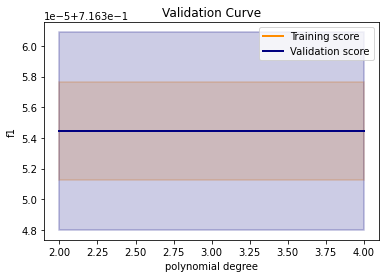

Training scores:

         cv1       cv2       cv3
0  0.716352  0.716352  0.716359
1  0.716352  0.716352  0.716359
2  0.716352  0.716352  0.716359

 ----------------------------------------------------------------------

Validation scores:

         cv1       cv2       cv3
0  0.716359  0.716359  0.716345
1  0.716359  0.716359  0.716345
2  0.716359  0.716359  0.716345


In [ ]:
xlabel = 'polynomial degree'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(deg_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(deg_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(deg_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(deg_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)]) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame( valid_scores, columns=[f'cv{i+1}' for i in range(cv)]) )

So polynomial degree of kernel doesn't impact training.

#### Validation on gamma

In [ ]:
scoring = 'f1'
cv = 3
gamma_list = [0.001,0.01,0.1]
train_scores, valid_scores = validation_curve(SVC(kernel ='rbf', C=.01), X_train, Y_train, 
                                              param_name="gamma",
                                              param_range=gamma_list , 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=1, 
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 58.0min finished


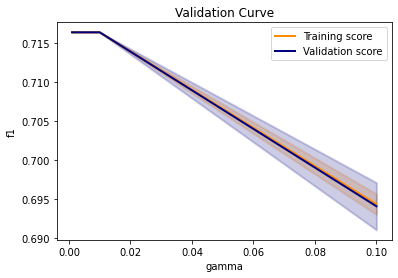

Training scores:

             cv1       cv2       cv3
0.001  0.716352  0.716352  0.716359
0.010  0.716352  0.716352  0.716359
0.100  0.696164  0.693094  0.693836

 ----------------------------------------------------------------------

Validation scores:

             cv1       cv2       cv3
0.001  0.716359  0.716359  0.716345
0.010  0.716359  0.716359  0.716345
0.100  0.692375  0.691570  0.698355


In [ ]:
xlabel = 'gamma'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(gamma_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(gamma_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(gamma_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(gamma_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=gamma_list))
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=gamma_list) )

## Best Model

In [16]:
clf = svm.SVC(kernel='rbf', gamma=.1, C=.01, probability=True)
# train model
start_train = time.time()
trained_model = clf.fit(X_train, Y_train)
runtime_train = start_train - time.time()
# predict data
start_pred = time.time()
Y_pred = trained_model.predict(X_test)
runtime_pred = start_pred - time.time()

### Classification Report
Print some information about the trained model such as training time, ... 

In [18]:
scoring = 'accuracy'

In [19]:
print('\nclassification report: \n')
from sklearn.metrics import classification_report, f1_score, accuracy_score
print(classification_report(Y_test, Y_pred))

EM1 = scoring
# mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS1 = accuracy_score(Y_train, clf.predict(X_train))
CPS1 = trained_model.score(X_test, Y_test)
F1_score = f1_score(Y_test, Y_pred, average='macro')
T1 = runtime_train
PT1 = runtime_pred
print( "Training Time was: " + str(T1))
print("Prediction Time was: " + str(PT1))


classification report: 

              precision    recall  f1-score   support

           0       0.57      0.27      0.37      8852
           1       0.59      0.84      0.69     11148

    accuracy                           0.59     20000
   macro avg       0.58      0.56      0.53     20000
weighted avg       0.58      0.59      0.55     20000

Training Time was: -3695.255345106125
Prediction Time was: -97.867600440979


### Confusion Matrix

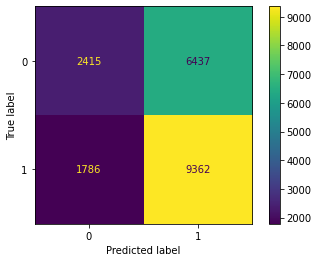

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=trained_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trained_model.classes_)
disp.plot()
plt.show()

### Precision Recall Curve

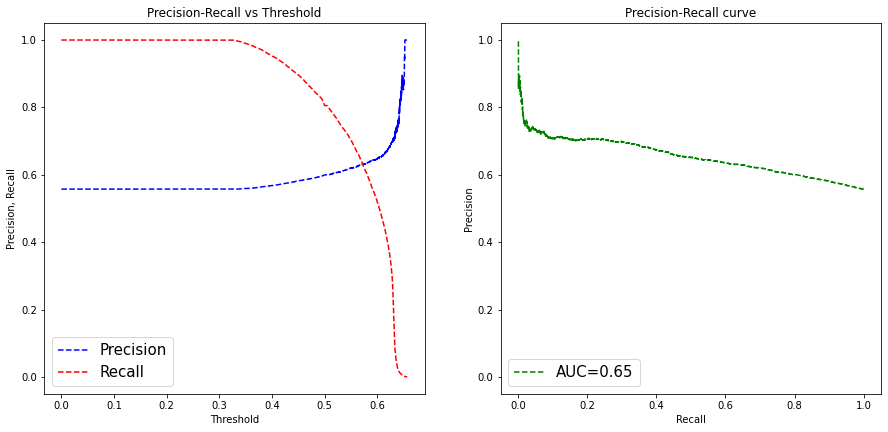

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#clf= SVC(gamma='scale' , probability=True)
#clf.fit(x_train,y_train)
Y_probs=trained_model.predict_proba(X_test) 
precision, recall, thresholds = precision_recall_curve(Y_test , Y_probs[:, 1]) 
thresholds=np.append(0,thresholds)

area = auc(recall, precision)
#print(area)

plt.figure(figsize=(15, 15))
ax1 = plt.subplot(221,xlabel='Threshold',ylabel='Precision, Recall' ,title='Precision-Recall vs Threshold')
ax1.plot(thresholds, precision, "b--", label="Precision")
ax1.plot(thresholds, recall, "r--", label="Recall")
plt.legend(loc="lower left",prop={'size': 15})

ax2 = plt.subplot(222,title='Precision-Recall curve',xlabel='Recall',ylabel='Precision')
ax2.plot( recall,precision,'g--',label='AUC={:.2f}'.format(area))
ax2.set( ylim=(-.05, 1.05))
plt.legend(loc="lower left",prop={'size': 15})

plt.show()

# SVM / CDM

Initialize and train svm model

In [ ]:
svc = svm.SVC(kernel='rbf',C=.1)

svc.fit(X2_train, Y2_train)
Y2_pred = svc.predict(X2_test)

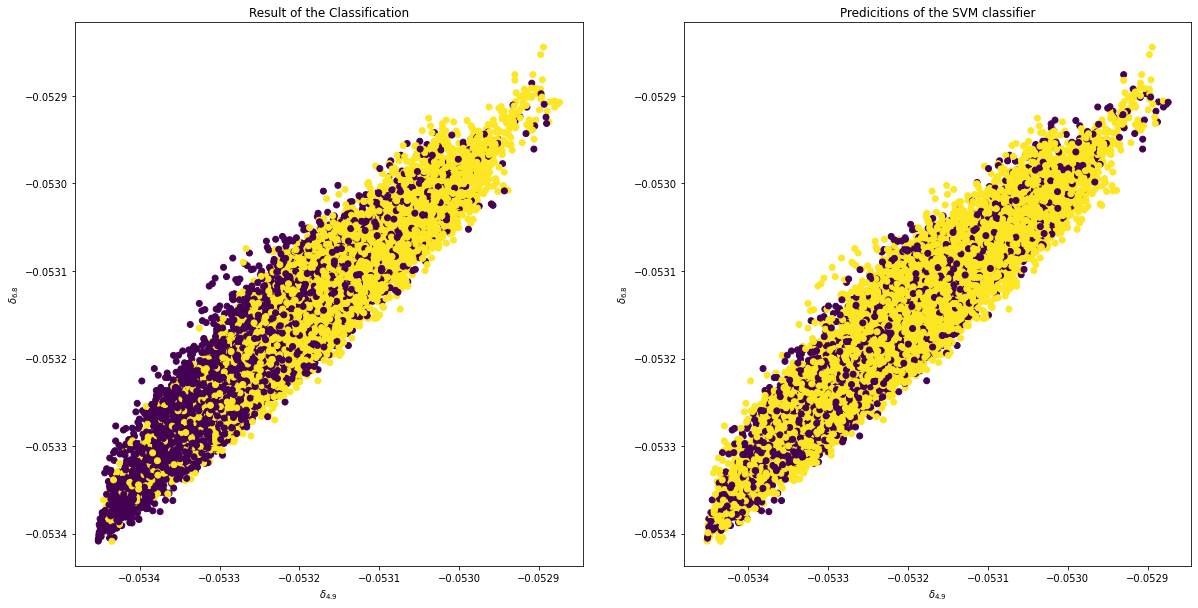

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$\delta_{4.9}$', ylabel='$\delta_{6.8}$' , title = 'Result of the Classification')

ax.scatter(*X2_test[:,6:8].T, c=Y2_test)    

ax = fig.add_subplot(122 , xlabel = '$\delta_{4.9}$ ', ylabel='$\delta_{6.8}$', title = 'Predicitions of the SVM classifier')
plt.scatter(*X2_test[:,6:8].T, c = Y2_pred)
plt.show()


In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(Y2_test, Y2_pred))

              precision    recall  f1-score   support

           0       0.58      0.33      0.42      8852
           1       0.60      0.81      0.69     11148

    accuracy                           0.60     20000
   macro avg       0.59      0.57      0.56     20000
weighted avg       0.59      0.60      0.57     20000



### Fine Tunning The Hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'C': [0.1,1,.01],  
                'gamma': [0.001,.1,.01,1], 
                'kernel': ['rbf', 'sigmoid']}

In [ ]:
# Random search of parameters, using 2 fold cross validation, 
# search across 6 different combinations, and use all available cores
print('start')
svc= svm.SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, n_iter=6, cv = 2, verbose=2, random_state=42, n_jobs = -1, refit=True)
# Fit the random search model
svc_random.fit(X2_train, Y2_train)

print(svc_random.best_params_)

start
Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [ ]:
print(svc_random.best_params_)

{'kernel': 'rbf', 'gamma': 0.1, 'C': 0.01}


In [ ]:
import pickle

# save the model to disk

filename = 'drive/MyDrive/svm_cdm_model.sav'
# pickle.dump(trained_model, open(filename, 'wb'))

# load the model from disk

clf_load = pickle.load(open(filename, 'rb'))


### Learning Curve


In [ ]:
cv = 4
scoring = 'f1'

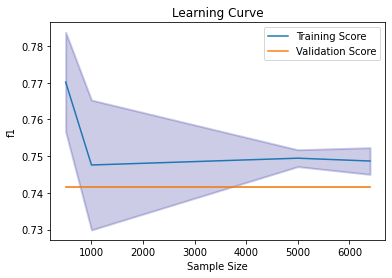

Training scores:

            cv1       cv2       cv3       cv4
100        NaN  0.726115  0.726115  0.726115
500   0.793727  0.762376  0.762376  0.762376
1000  0.778253  0.737374  0.737374  0.737374
5000  0.753428  0.748122  0.748122  0.748122
6400  0.754985  0.746573  0.746573  0.746573

 ----------------------------------------------------------------------

Validation scores:

            cv1       cv2       cv3       cv4
100        NaN  0.741505  0.741505  0.741505
500   0.741505  0.741505  0.741505  0.741505
1000  0.741505  0.741505  0.741505  0.741505
5000  0.741505  0.741505  0.741505  0.741505
6400  0.741505  0.741505  0.741505  0.741505


In [ ]:
ns = [100,500,1000,5000,6400]
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel ='rbf', C=.01, gamma=0.1), X2, Y2, train_sizes=ns, cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

In [ ]:
# best split
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = 100000, random_state=0) , random_state=0, test_size =.09)

### Validation Curve


#### Validation on gamma

In [ ]:
scoring = 'f1'
cv = 3
gamma_list = [0.001,0.01,0.1]
train_scores, valid_scores = validation_curve(SVC(kernel ='rbf', C=.01), X2_train, Y2_train, 
                                              param_name="gamma",
                                              param_range=gamma_list , 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=1, 
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 57.9min finished


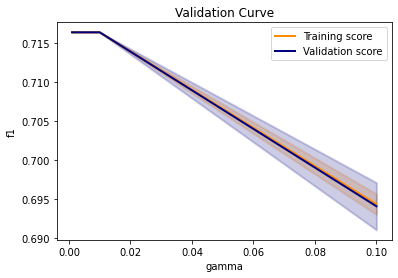

Training scores:

             cv1       cv2       cv3
0.001  0.716352  0.716352  0.716359
0.010  0.716352  0.716352  0.716359
0.100  0.696164  0.693094  0.693836

 ----------------------------------------------------------------------

Validation scores:

             cv1       cv2       cv3
0.001  0.716359  0.716359  0.716345
0.010  0.716359  0.716359  0.716345
0.100  0.692375  0.691570  0.698355


In [ ]:
xlabel = 'gamma'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(gamma_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(gamma_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(gamma_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(gamma_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=gamma_list))
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=gamma_list) )

## Best Model

In [34]:
clf = svm.SVC(kernel='rbf', gamma=.1, C=.01, probability=True)
# train model
start_train = time.time()
trained_model = clf.fit(X2_train, Y2_train)
runtime_train = start_train - time.time()
# predict data
start_pred = time.time()
Y2_pred = trained_model.predict(X2_test)
runtime_pred = start_pred - time.time()

### Classification Report
Print some information about the trained model such as training time, ... 

In [35]:
print('\nclassification report: \n')
from sklearn.metrics import classification_report
print(classification_report(Y2_test, Y2_pred))

EM2 = scoring
# mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS2 = accuracy_score(Y2_train, clf.predict(X2_train))
CPS2 = trained_model.score(X2_test, Y2_test)
F1_score_c = f1_score(Y2_test, Y2_pred, average='macro')
T2 = runtime_train
PT2 = runtime_pred
print( "Training Time was: " + str(T2))
print("Prediction Time was: " + str(PT2))


classification report: 

              precision    recall  f1-score   support

           0       0.57      0.27      0.37      8852
           1       0.59      0.84      0.69     11148

    accuracy                           0.59     20000
   macro avg       0.58      0.56      0.53     20000
weighted avg       0.58      0.59      0.55     20000

Training Time was: -3680.8333535194397
Prediction Time was: -97.55358242988586


### Confusion Matrix

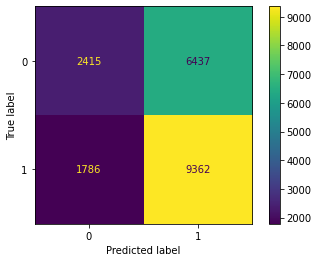

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y2_test, Y2_pred, labels=trained_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trained_model.classes_)
disp.plot()
plt.show()

### Precision Recall Curve

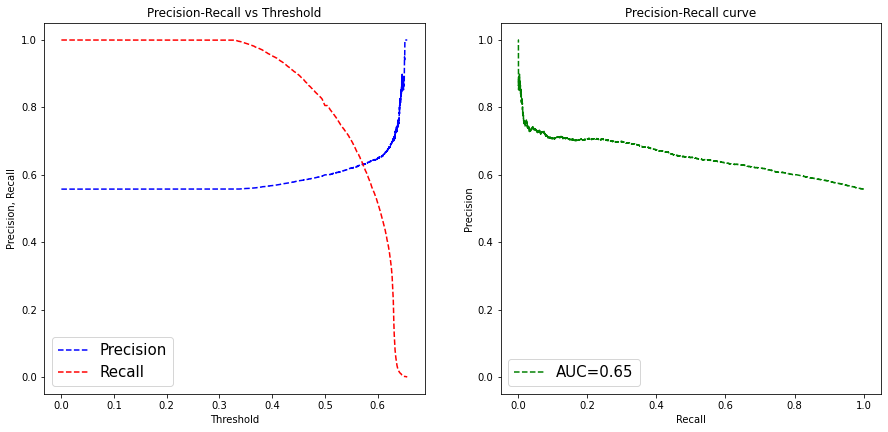

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#clf= SVC(gamma='scale' , probability=True)
#clf.fit(x_train,y_train)
Y2_probs=trained_model.predict_proba(X2_test) 
precision, recall, thresholds = precision_recall_curve(Y2_test , Y2_probs[:, 1]) 
thresholds=np.append(0,thresholds)

area = auc(recall, precision)
#print(area)

plt.figure(figsize=(15, 15))
ax1 = plt.subplot(221,xlabel='Threshold',ylabel='Precision, Recall' ,title='Precision-Recall vs Threshold')
ax1.plot(thresholds, precision, "b--", label="Precision")
ax1.plot(thresholds, recall, "r--", label="Recall")
plt.legend(loc="lower left",prop={'size': 15})

ax2 = plt.subplot(222,title='Precision-Recall curve',xlabel='Recall',ylabel='Precision')
ax2.plot( recall,precision,'g--',label='AUC={:.2f}'.format(area))
ax2.set( ylim=(-.05, 1.05))
plt.legend(loc="lower left",prop={'size': 15})

plt.show()

# Comparing Models

A table is created to compare the five recently-traind models above. It includes evaluation metric(s), training time and prediction time of each models. Also, we sorted models based on their performance from different aspects. 

In [43]:
table = pd.DataFrame({'Name':['Neutrino','CDM'],
                        'Evaluation Metric(s)': [EM1, EM2],
                        'Corresponding Validation Score': [CVS1, CVS2],
                        'Corresponding Prediction Score':  [CPS1, CPS2],
                        'Corresponding F1 Prediction Score': [F1_score, F1_score_c],
                        'Training Time': [T1, T2],
                        'Prediction Time': [PT1, PT2]
})

print('Sort models based on their validation scores: \n' + str(table.sort_values(by=['Corresponding Validation Score'], ascending= False).loc[:, ['Name', 'Corresponding Validation Score']]))
print('\nSort models based on their prediction scores: \n' + str(table.sort_values(by=['Corresponding Prediction Score'], ascending= False).loc[:, ['Name', 'Corresponding Prediction Score']]))
print('\nSort models based on their f1 prediction scores: \n' + str(table.sort_values(by=['Corresponding F1 Prediction Score'], ascending= True).loc[:, ['Name', 'Corresponding F1 Prediction Score']]))
print('\nSort models based on their training time: \n' + str(table.sort_values(by=['Training Time'], ascending= True).loc[:, ['Name', 'Training Time']]))
print('\nSort models based on their prediction time: \n' + str(table.sort_values(by=['Prediction Time'], ascending= True).loc[:, ['Name', 'Prediction Time']]))


Sort models based on their validation scores: 
       Name  Corresponding Validation Score
0  Neutrino                        0.584125
1       CDM                        0.584125

Sort models based on their prediction scores: 
       Name  Corresponding Prediction Score
0  Neutrino                         0.58885
1       CDM                         0.58885

Sort models based on their f1 prediction scores: 
       Name  Corresponding F1 Prediction Score
0  Neutrino                           0.532438
1       CDM                           0.532438

Sort models based on their training time: 
       Name  Training Time
0  Neutrino   -3695.255345
1       CDM   -3680.833354

Sort models based on their prediction time: 
       Name  Prediction Time
0  Neutrino       -97.867600
1       CDM       -97.553582
